# Лабораторная работа №5.
## Сети с обратными связями.
### Выполнила: Михеева Кристина Олеговна
#### Группа М8О-407Б-20
##### Вариант: 15

## Цель работы

Целью работы является исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.


## Ход работы

## Задание 1
Использовать сеть Элмана для распознавания динамических образов. Проверить качество распознавания.


Для начала извлечем некоторые библиотеки, которые помогут нам в выполнении данной работы. Для построение графика нам понадобится библиотека - *matplotlib*, для выполнение операций с массивами мы подключим - *numpy*, а также библиотеку для обучния нейронных сетей - *torch*

In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from collections import defaultdict



Задаем данные из условия варианта.

In [3]:
def g1(k):
    return np.sin(4 * np.pi * k)

def g2(k):
    return np.sin(np.sin(k)*k**2 - 0.1)

h = 0.025

k1 = np.arange(0, 1, h)
k2 = np.arange(0.48, 2.71, h)


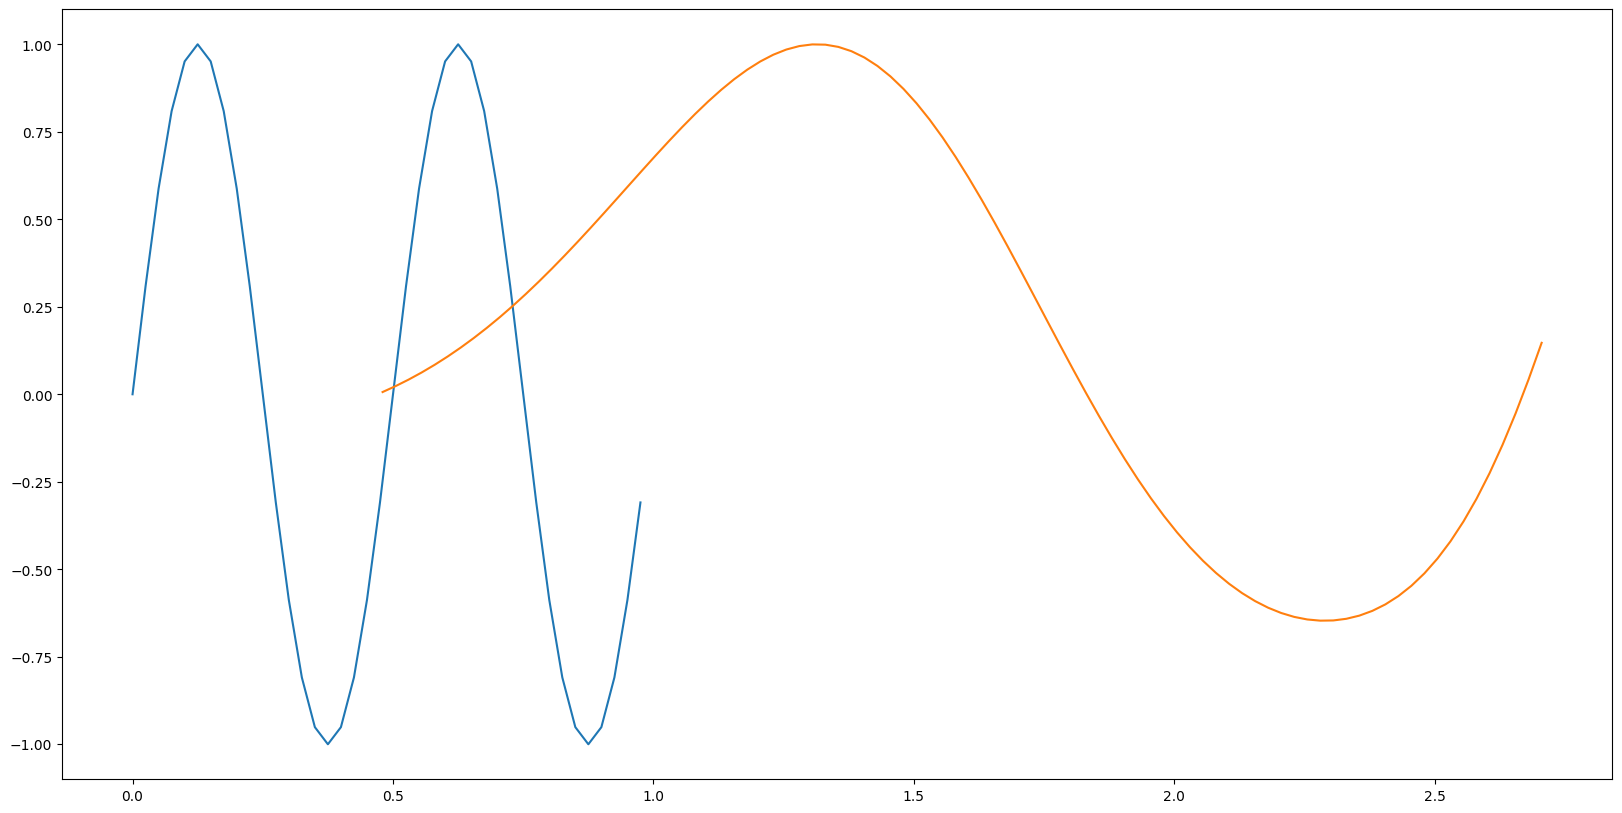

In [4]:
figure = plt.figure(figsize = (20, 10))

plt.plot(k1, g1(k1))
plt.plot(k2, g2(k2))
plt.show()

Для обучения будем использовать сеть Элмана. Реализуем слой для нее.

In [8]:
class Elman(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Elman, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w1 = nn.Parameter(torch.randn(self.input_dim, self.output_dim))
        self.w2 = nn.Parameter(torch.randn(self.output_dim, self.output_dim))
        self.b = nn.Parameter(torch.randn(self.output_dim))
        self.prev = torch.zeros(self.output_dim)

    def clear_memory(self):
        self.prev = torch.zeros(self.output_dim)

    def forward(self, input):
        d = torch.matmul(self.prev, self.w2)
        out = torch.matmul(input, self.w1)
        out = torch.add(out, d)
        out = torch.add(out, self.b)
        out = torch.tanh(out)
        self.prev = out.clone().detach()
        return out

Сгенерируем датасет для обучения. В качестве входных признаков будем брать несколько подряд идущих элементов.

In [9]:
def make_signal(r1 = 7, r2 = 0, r3 = 3):
    signal = np.concatenate((np.tile(g1(k1), r1), g2(k2), np.tile(g1(k1), r2), g2(k2), np.tile(g1(k1), r3), g2(k2)), axis = 0, dtype = np.float32)
    labels = np.concatenate((np.full((len(k1) * r1,), -1), np.ones((len(k2),)), np.full((len(k1)*r2,), -1), np.ones((len(k2),)),  np.full((len(k1) * r3,), -1), np.ones((len(k2),))), axis = 0, dtype = np.float32)

    return signal, labels

def get_train_data(signal, labels, window = 1):
    signal_seq = [np.array(signal[i:i+window], dtype = np.float32) for i in range(0, len(signal) - window)]
    labels_seq = [np.array(labels[i:i+window], dtype = np.float32) for i in range(0, len(labels) - window)]
    output = [(x,y) for x, y in zip(signal_seq, labels_seq)]
    return output

In [ ]:
epochs = 300
window = 8

elman = Elman(input_dim=window, output_dim=8)
linear = nn.Linear(in_features=8, out_features=window)

model = nn.Sequential(elman, linear)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

signal, labels = make_signal(r1=7, r2=0, r3=3)
train_dataset = get_train_data(signal, labels, window=window)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
model.train()

train_loss = []

for i in range(epochs):
    elman.clear_memory()
    last_loss = []
    for input, output_gt in train_loader:
        output = model(input)
        crit = nn.MSELoss()
        loss = torch.sqrt(crit(output_gt, output))
        last_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(last_loss))

    model.eval()

elman.clear_memory()

predict = []

for x, y in train_dataset:
    predict.append(model(torch.tensor(x)).detach().numpy().item(0))

predict = np.array(predict)
predict[predict > 0] = 1
predict[predict < 0] = -1


Таргеты - тип сигнала в каждой точке промежутка.

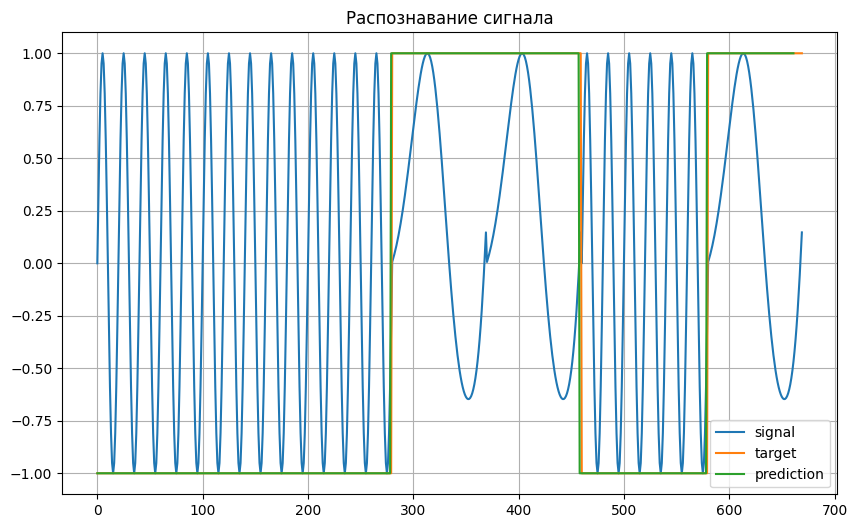

In [18]:
plt.figure(figsize=(10, 6))
plt.title('Распознавание сигнала')

plt.plot(signal, label='signal')
plt.plot(labels, label='target')
plt.plot(predict, label='prediction')

plt.grid()
plt.legend()
plt.show()

Сеть почти всегда правильно угадывает таргет, но с некоторыми погрешностями на границах сигналов.

## Задание 2

Использовать сеть Хопфилда для распознавания статических образов. Проверить качество распознавания.

Пропишем матрицы заданных образов из варианта.

In [14]:
three = np.matrix([
                0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
                0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
                0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
                0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
                0, 0, 1, 1, 1, 1, 1, 1, 0, 0], dtype=np.float32)

six = np.matrix([
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
                1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                1, 0, 0, 0, 0, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
                1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
                1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
                1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=np.float32)

zero = np.matrix([
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
               0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
               0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
               0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32)


Для обучения будем использовать сеть Хопфилда. Реализуем слой для нее.

In [70]:
class Hopfield(nn.Module):
    def __init__(self, input_dim):
        super(Hopfield, self).__init__()
        self.w = nn.Parameter(torch.zeros(input_dim, input_dim))
        self.b = nn.Parameter(torch.zeros(input_dim))
        self.prev = torch.zeros(input_dim)

    def set_initial_value(self, value):
        self.prev = value.clone()

    def forward(self, input=0):
        out = torch.matmul(self.prev.float(), self.w.float())
        out = torch.add(out, self.b.float())
        out = torch.clamp(out, min=-1, max=1)
        self.prev = out.clone()
        return out


In [196]:
three_tensor = torch.tensor(three.reshape(1, -1))
six_tensor = torch.tensor(six.reshape(1, -1))
zero_tensor = torch.tensor(zero.reshape(1, -1))

In [197]:
hopfield = Hopfield(input_dim=len(zero_tensor[0]))

 Обучение сети на эталонных образах.

In [198]:
epochs = 1500
optimizer = torch.optim.Adam(hopfield.parameters(), lr=1e-4)
training_history = defaultdict(list)
hopfield.train()

# Обучение на нуле
for epoch in range(epochs):
    losses = []
    hopfield.set_initial_value(zero_tensor)

    out = hopfield()
    loss = nn.MSELoss()(out, zero_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    training_history['loss'].append(np.mean(losses))

In [199]:
# Обучение на шестерки
epochs = 1500
optimizer = torch.optim.Adam(hopfield.parameters(), lr=1e-4)
training_history = defaultdict(list)
hopfield.train()

for epoch in range(epochs):
    losses = []
    hopfield.set_initial_value(six_tensor)

    out = hopfield()
    loss = nn.MSELoss()(out, six_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    training_history['loss'].append(np.mean(losses))

In [200]:
# Обучение на тройки
epochs = 1500
optimizer = torch.optim.Adam(hopfield.parameters(), lr=1e-4)
training_history = defaultdict(list)
hopfield.train()

for epoch in range(epochs):
    losses = []
    hopfield.set_initial_value(three_tensor)

    out = hopfield()
    loss = nn.MSELoss()(out, three_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    training_history['loss'].append(np.mean(losses))

Создадим шум для зашумления образов.

In [210]:
def add_noise(image, noise_level = 0.2):
    noise = np.random.choice([0, 1], size=image.shape, p=[1 - noise_level, noise_level])
    return (image + noise) % 2

Эталон

In [201]:
zero_np = zero.reshape(12, 10)
six_np = six.reshape(12, 10)
three_np = three.reshape(12, 10)

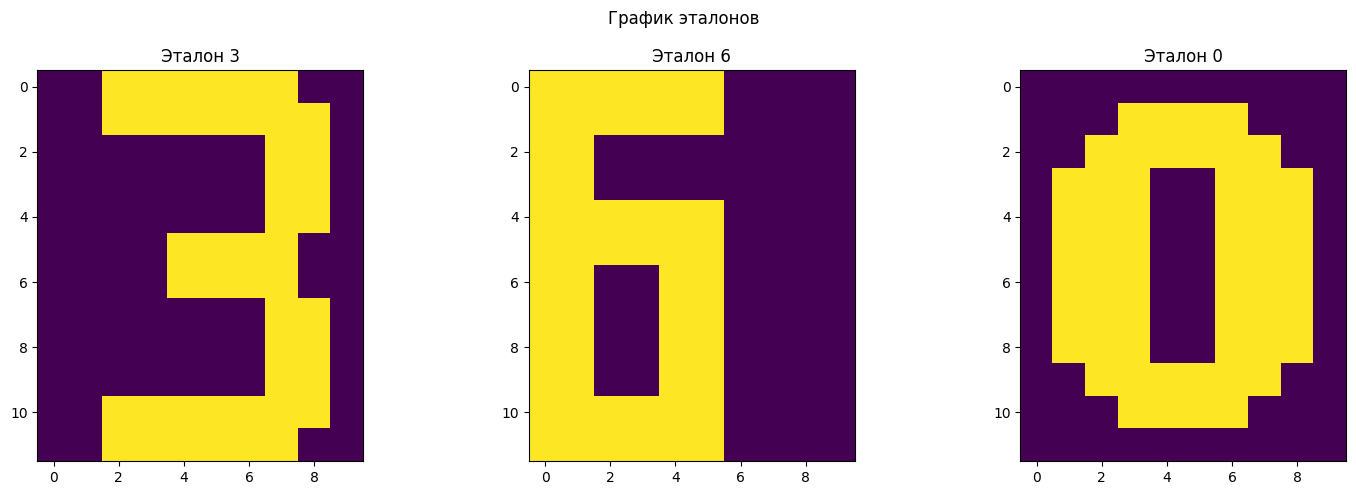

In [202]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(three_np, cmap='viridis')
plt.title('Эталон 3')

plt.subplot(1, 3, 2)
plt.imshow(six_np, cmap='viridis')
plt.title('Эталон 6')

plt.subplot(1, 3, 3)
plt.imshow(zero_np, cmap='viridis')
plt.title('Эталон 0')

plt.suptitle('График эталонов')
plt.tight_layout()
plt.show()

Зашумление 20%

In [203]:
noise_level = 0.2
noisy_zero = add_noise(zero, noise_level)
noisy_six = add_noise(six, noise_level)
noisy_three = add_noise(three, noise_level)

noisy_zero_tensor = torch.tensor(noisy_zero.reshape(1, -1))
noisy_six_tensor = torch.tensor(noisy_six.reshape(1, -1))
noisy_three_tensor = torch.tensor(noisy_three.reshape(1, -1))

In [204]:
noisy_three_np = noisy_three_tensor.detach().numpy().reshape(12, 10)
noisy_six_np = noisy_six_tensor.detach().numpy().reshape(12, 10)
noisy_zero_np = noisy_zero_tensor.detach().numpy().reshape(12, 10)

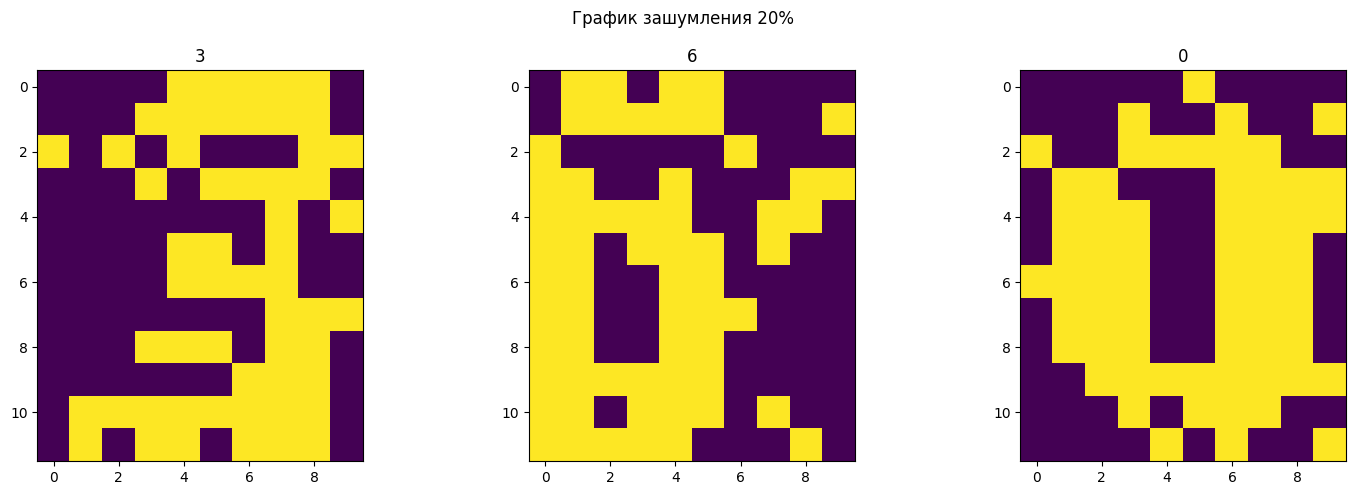

In [205]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(noisy_three_np, cmap='viridis')
plt.title('3')

plt.subplot(1, 3, 2)
plt.imshow(noisy_six_np, cmap='viridis')
plt.title('6')

plt.subplot(1, 3, 3)
plt.imshow(noisy_zero_np, cmap='viridis')
plt.title('0')

plt.suptitle('График зашумления 20%')
plt.tight_layout()
plt.show()


Зашумление 30%

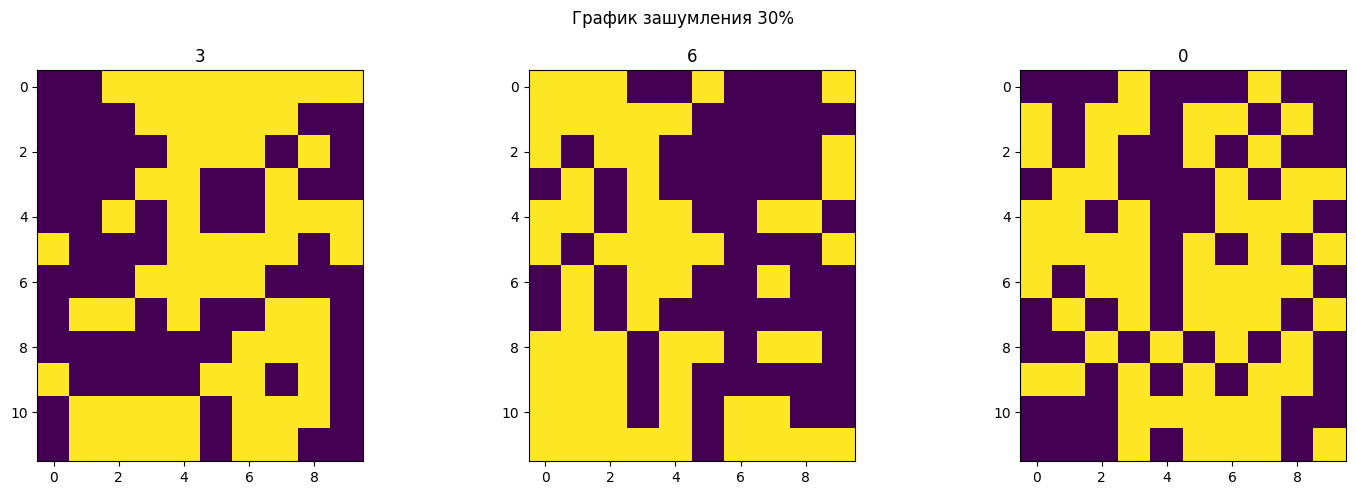

In [206]:
noisy_zero = add_noise(zero, noise_level = 0.3)
noisy_six = add_noise(six, noise_level = 0.3)
noisy_three = add_noise(three, noise_level = 0.3)

noisy_zero_tensor = torch.tensor(noisy_zero.reshape(1, -1))
noisy_six_tensor = torch.tensor(noisy_six.reshape(1, -1))
noisy_three_tensor = torch.tensor(noisy_three.reshape(1, -1))

noisy_three_np = noisy_three_tensor.detach().numpy().reshape(12, 10)
noisy_six_np = noisy_six_tensor.detach().numpy().reshape(12, 10)
noisy_zero_np = noisy_zero_tensor.detach().numpy().reshape(12, 10)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(noisy_three_np, cmap='viridis')
plt.title('3')

plt.subplot(1, 3, 2)
plt.imshow(noisy_six_np, cmap='viridis')
plt.title('6')

plt.subplot(1, 3, 3)
plt.imshow(noisy_zero_np, cmap='viridis')
plt.title('0')

plt.suptitle('График зашумления 30%')
plt.tight_layout()
plt.show()

Восстановление зашумленных образов.

In [207]:

recovered_zero = hopfield.set_initial_value(noisy_zero_tensor)
recovered_six = hopfield.set_initial_value(noisy_six_tensor)
recovered_three = hopfield.set_initial_value(noisy_three_tensor)

hopfield.set_initial_value(noisy_zero_tensor)
recovered_zero = hopfield()
hopfield.set_initial_value(noisy_six_tensor)
recovered_six = hopfield()
hopfield.set_initial_value(noisy_three_tensor)
recovered_three = hopfield()

In [208]:
recovered_zero_np = recovered_zero.detach().numpy().reshape(12, 10)
recovered_six_np = recovered_six.detach().numpy().reshape(12, 10)
recovered_three_np = recovered_three.detach().numpy().reshape(12, 10)

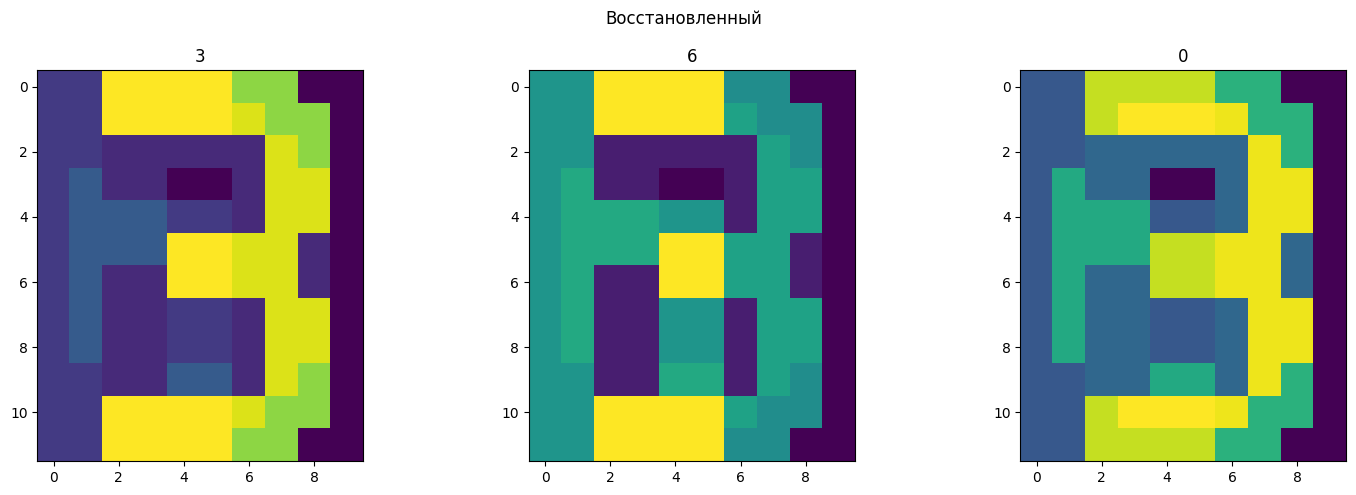

In [209]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(recovered_three_np, cmap='viridis')
plt.title('3')

plt.subplot(1, 3, 2)
plt.imshow(recovered_six_np, cmap='viridis')
plt.title('6')

plt.subplot(1, 3, 3)
plt.imshow(recovered_zero_np, cmap='viridis')
plt.title('0')

plt.suptitle('Восстановленный')
plt.tight_layout()
plt.show()


## Вывод
В данной лабораторной работе я познакомилась с рекурентными сетями, а именно с сетью Элмана и Хопфилда.Были представлены примеры динамических и статических образов. За счет использования информации о предыдущем состоянии, рекуррентные сети могут распознавать сложные динамические образы силами одного линейного слоя. Однако такие сети значительно сложнее в настройке и обучении.